In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# --- Load data ---
df = pd.read_excel('nasdaq-1.xls')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(10)

Shape: (2112, 3)
Columns: ['NQTIMESINCEMIDNIGHT', 'NQ_RET', 'DAY']


,NQTIMESINCEMIDNIGHT,NQ_RET,DAY
0,33599860,NaN,1
1,33899996,-0.001143,1
2,34199999,-0.000143,1
3,34499888,0.001715,1
4,34799976,0.000428,1
5,35099970,-0.000571,1
6,35399992,0.003136,1
7,35699983,0.001422,1
8,35999977,-0.000142,1
9,36299999,-0.000355,1


Trading hours: 9.33 to 14.75
Unique days: 32
Obs per day: ~65
Total rows: 2111


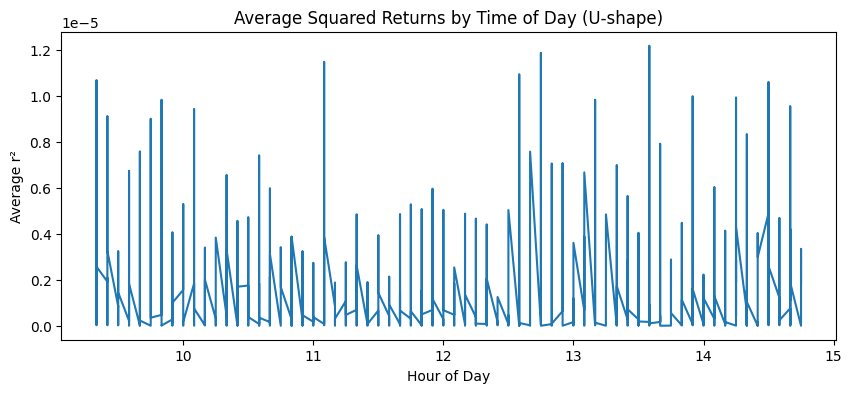

In [26]:
# --- Prepare data ---
# Use actual column names from the file
df.columns = ['timestamp_ms', 'ret', 'day']

# Drop the first row (NaN return)
df = df.dropna(subset=['ret']).reset_index(drop=True)

# Convert timestamp from milliseconds to seconds past midnight
df['seconds'] = df['timestamp_ms'] / 1000

# Convert to hours past midnight (for interpretability)
df['hours'] = df['seconds'] / 3600

t_min = df['hours'].min()
t_max = df['hours'].max()
print(f"Trading hours: {t_min:.2f} to {t_max:.2f}")
print(f"Unique days: {df['day'].nunique()}")
print(f"Obs per day: ~{len(df) // df['day'].nunique()}")
print(f"Total rows: {len(df)}")

# Squared returns (this is what we model with φ(t))
df['ret2'] = df['ret'] ** 2

# Quick look at the U-shape: average squared return by time of day
avg_vol = df.groupby('seconds')['ret2'].mean()
plt.figure(figsize=(10, 4))
plt.plot(avg_vol.index / 3600, avg_vol.values)
plt.xlabel('Hour of Day')
plt.ylabel('Average r²')
plt.title('Average Squared Returns by Time of Day (U-shape)')
plt.show()

# Q2 A
---
Fit a quadratic spline for $\phi(t)$ to capture the U-shape in intraday volatility.

Since $\phi(t) = E(r_t^2 \mid t)$, we estimate it by regressing $r_t^2$ on a function of time of day.

Quadratic coefficients (t², t, const): [ 7.42433088e-15 -6.52743511e-10  1.51069887e-05]


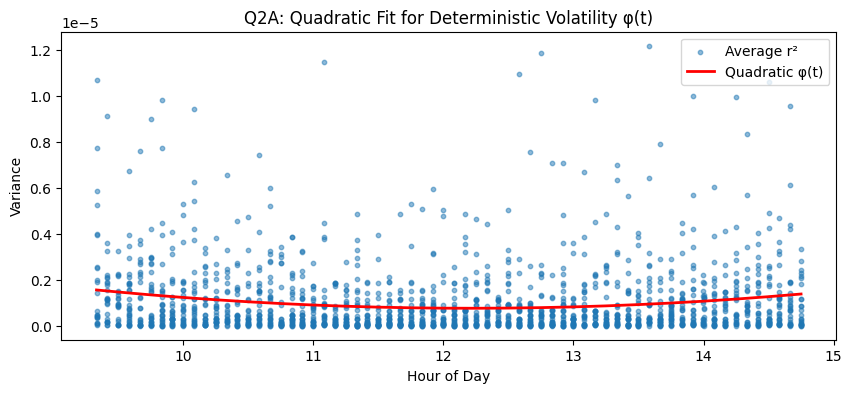


Quadratic: φ(t) = 7.4243e-15·t² + -6.5274e-10·t + 1.5107e-05


In [27]:
from numpy.polynomial import polynomial as P

# Use seconds past midnight as the time variable
t = df['seconds'].values
r2 = df['ret2'].values

# Fit a quadratic: φ(t) = a + b·t + c·t²
# np.polyfit returns coefficients [c, b, a] (highest degree first)
quad_coeffs = np.polyfit(t, r2, deg=2)
print("Quadratic coefficients (t², t, const):", quad_coeffs)

# Compute fitted values for all observations
df['phi_t'] = np.polyval(quad_coeffs, t)

# Ensure φ(t) > 0 everywhere (floor at a small positive number)
df['phi_t'] = np.maximum(df['phi_t'], 1e-12)

# Plot: average r² vs fitted φ(t) over time of day
avg_r2 = df.groupby('seconds')['ret2'].mean()
avg_phi = df.groupby('seconds')['phi_t'].mean()

plt.figure(figsize=(10, 4))
plt.scatter(avg_r2.index / 3600, avg_r2.values, s=10, alpha=0.5, label='Average r²')
plt.plot(avg_phi.index / 3600, avg_phi.values, color='red', linewidth=2, label='Quadratic φ(t)')
plt.xlabel('Hour of Day')
plt.ylabel('Variance')
plt.title('Q2A: Quadratic Fit for Deterministic Volatility φ(t)')
plt.legend()
plt.show()

print(f"\nQuadratic: φ(t) = {quad_coeffs[0]:.4e}·t² + {quad_coeffs[1]:.4e}·t + {quad_coeffs[2]:.4e}")

# Q2 B
---
Plot the estimated $\phi(t)$ for a single day.

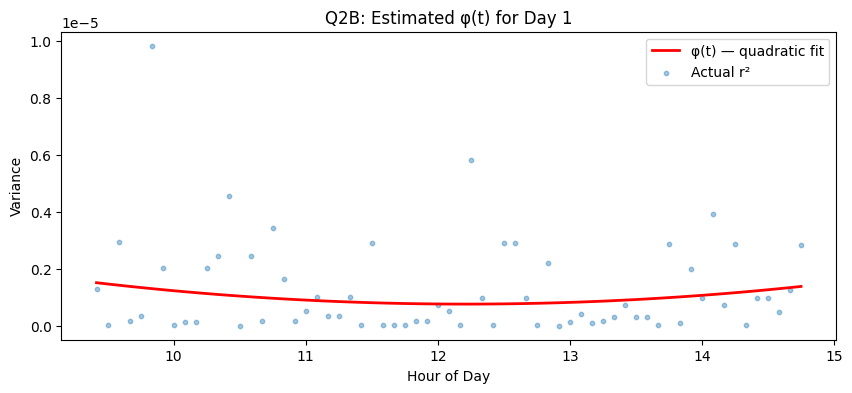

In [28]:
# Pick day 1 as the example
day1 = df[df['day'] == 1].copy()

plt.figure(figsize=(10, 4))
plt.plot(day1['hours'], day1['phi_t'], color='red', linewidth=2, label='φ(t) — quadratic fit')
plt.scatter(day1['hours'], day1['ret2'], s=10, alpha=0.4, label='Actual r²')
plt.xlabel('Hour of Day')
plt.ylabel('Variance')
plt.title('Q2B: Estimated φ(t) for Day 1')
plt.legend()
plt.show()

# Q2 C
---
Create the de-seasonalized returns $\tilde{r}_t = \frac{r_t}{\sqrt{\phi(t)}}$ and fit a GARCH model.

This series should follow a pure GARCH process with unconditional variance ≈ 1.

Rows after cleaning: 2111
Unconditional variance of r_tilde: 0.9998  (should be ≈ 1)
Mean of r_tilde:                   0.036017
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2928.40
Distribution:                  Normal   AIC:                           5864.80
Method:            Maximum Likelihood   BIC:                           5887.42
                                        No. Observations:                 2111
Date:                Fri, Feb 20 2026   Df Residuals:                     2110
Time:                        13:12:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------

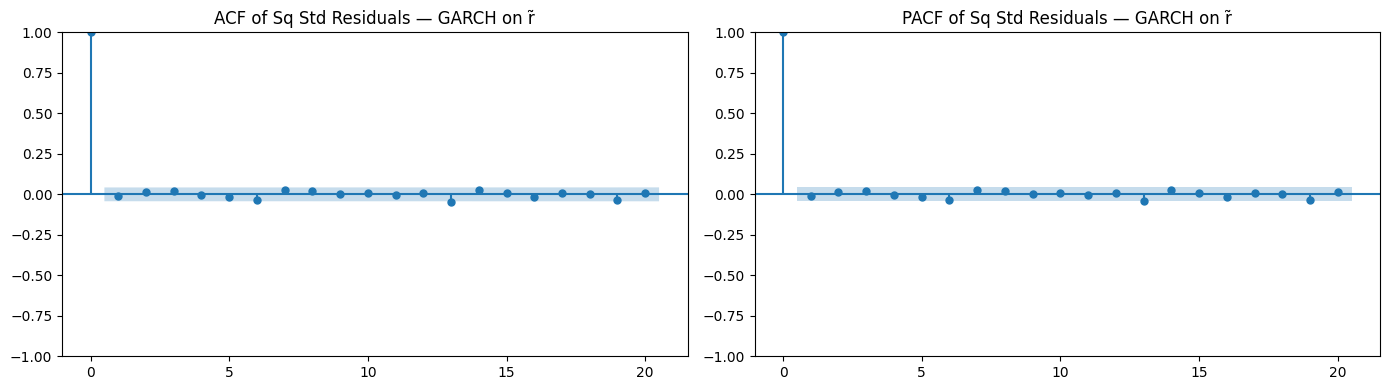


Ljung-Box test on squared standardized residuals:
      lb_stat  lb_pvalue
5    2.060627   0.840694
10   7.413135   0.685951
15  13.973963   0.527505
20  17.606067   0.613341


In [29]:
# De-seasonalize: divide returns by sqrt(φ(t))
df['r_tilde'] = df['ret'] / np.sqrt(df['phi_t'])

# Drop any NaN/inf rows
mask = np.isfinite(df['r_tilde'])
df = df[mask].reset_index(drop=True)

print(f"Rows after cleaning: {len(df)}")
print(f"Unconditional variance of r_tilde: {df['r_tilde'].var():.4f}  (should be ≈ 1)")
print(f"Mean of r_tilde:                   {df['r_tilde'].mean():.6f}")

# Fit GARCH(1,1) on de-seasonalized returns
r_tilde = df['r_tilde'].values
garch_spec = arch_model(r_tilde, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
garch_fit = garch_spec.fit(disp='off')
print(garch_fit.summary())

# Store conditional variance h_t for part d
df['h_t'] = garch_fit.conditional_volatility ** 2

# Diagnostics: squared standardized residuals
std_resid = garch_fit.resid / garch_fit.conditional_volatility
std_resid_sq = std_resid ** 2

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(std_resid_sq, lags=20, ax=axes[0], title='ACF of Sq Std Residuals — GARCH on r̃')
plot_pacf(std_resid_sq, lags=20, ax=axes[1], title='PACF of Sq Std Residuals — GARCH on r̃')
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(std_resid_sq, lags=[5, 10, 15, 20], return_df=True)
print('\nLjung-Box test on squared standardized residuals:')
print(lb)

# Q2 D
---
$E(r_t^2 \mid F_{t-1}) = h_t \phi_t$. Plot $\sqrt{\phi(t)}$ and $\sqrt{h_t \phi_t}$ on the same picture for one day.

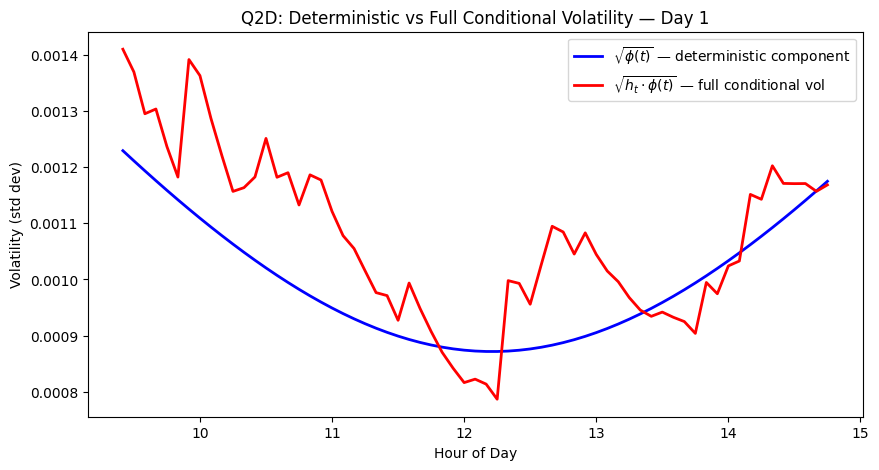

In [30]:
# Pick day 1 for the comparison plot
day1 = df[df['day'] == 1].copy()

# sqrt(φ(t)) — the deterministic volatility component (same every day)
# sqrt(h_t · φ(t)) — the full conditional volatility (deterministic × GARCH)
day1['sqrt_phi'] = np.sqrt(day1['phi_t'])
day1['sqrt_h_phi'] = np.sqrt(day1['h_t'] * day1['phi_t'])

plt.figure(figsize=(10, 5))
plt.plot(day1['hours'], day1['sqrt_phi'], color='blue', linewidth=2,
         label=r'$\sqrt{\phi(t)}$ — deterministic component')
plt.plot(day1['hours'], day1['sqrt_h_phi'], color='red', linewidth=2,
         label=r'$\sqrt{h_t \cdot \phi(t)}$ — full conditional vol')
plt.xlabel('Hour of Day')
plt.ylabel('Volatility (std dev)')
plt.title('Q2D: Deterministic vs Full Conditional Volatility — Day 1')
plt.legend()
plt.show()